# Cyclo-octane

The goal of this notebook is to understand the topology of the energy landscape of cyclo-octane.

- Martin, Shawn et al. _Topology of cyclo-octane energy landscape._ **The Journal of chemical physics** vol. 132,23 (2010)
- Stolz, B. J., Tanner, J., Harrington, H. A., & Nanda, V.  _Geometric anomaly detection in data._ **Proceedings of the National Academy of Sciences of the United States of America**, 117(33), 19664–19669 (2020).

<img src='figures/Conformation-space-of-cyclo-octane.jpeg' width="400" height="100"> 

**Conformation space of cyclo-octane.** The set of conformations of cyclo-octane can be represented as a surface in a high- dimensional space. (a) Various conformations of cyclo-octane. (b) These conformations are represented by the 3D coordinates of their atoms. The coordinates are concatenated into vectors and shown as columns of a data matrix. As an example, the entry $c_{1,1,x}$ of the matrix denotes the $x$-coordinate of the first carbon atom in the first molecule. (c) The Isomap projection is used to obtain a lower dimensional visualization of the data. 

## Point cloud

In [1]:
import scipy.io
data = scipy.io.loadmat('data/pointsCycloOctane.mat')['pointsCycloOctane']
data.shape

(6040, 24)

Rips(maxdim=2, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)


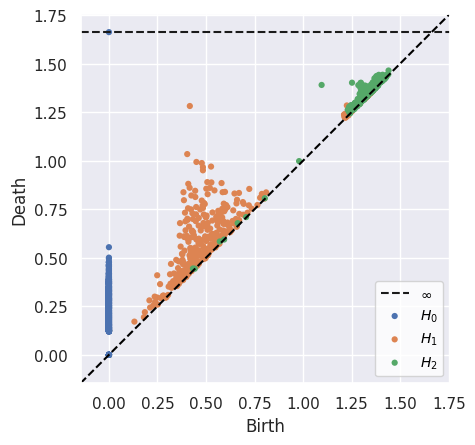

In [4]:
import numpy as np
import seaborn as sns
from ripser import Rips

sns.set()
rips = Rips(maxdim = 2)
dgm = rips.fit_transform(data[np.random.randint(0,data.shape[0]-1, 1000)])
rips.plot(dgm)

## Visualization

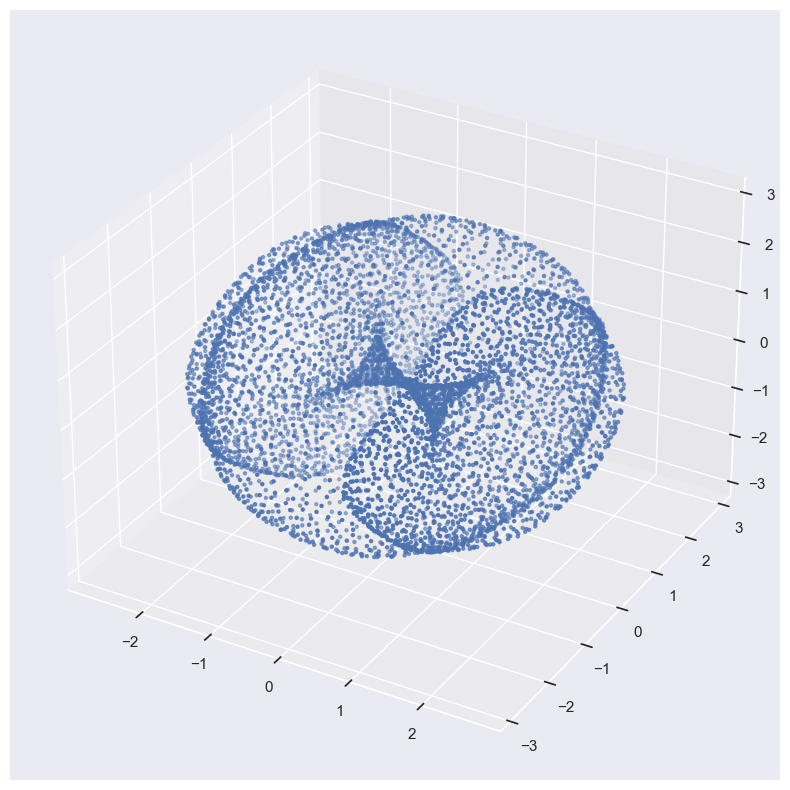

In [11]:
from sklearn.manifold import Isomap
import matplotlib.pyplot as plt

embedding = Isomap(n_components= 3, n_neighbors=10)
embedding_data = embedding.fit_transform(data)

sns.set()
fig = plt.figure(figsize = (10,10))
ax = fig.add_subplot(projection='3d')
ax.scatter(embedding_data[:,0], embedding_data[:,1], embedding_data[:,2], s=5);

## Geometric anomalies

In [22]:
from scipy.spatial import distance_matrix

def local_neighborhood(data, scale):
    D = distance_matrix(data, data)
    n = scale[1]-scale[0]
    local_neigh = np.ndarray(shape=(len(D),n), dtype=int, order='F')
    radius = np.ndarray(shape=(len(D),2), dtype=float, order='F')
    for i in range(len(D)):
        local_neigh[i] = np.argsort(D[i])[scale[0]:scale[1]]
    D.sort()
    for i in range(len(D)):
        radius[i] = [D[i][scale[0]], D[i][scale[1]]]
    return local_neigh, radius

    
def compute_local_persistence(data, scale):
    k1 = scale[0]
    k2 = scale[1]
    
    local_neigh, radius = local_neighborhood(data, [k1, k2])
    
    rips = Rips()
    mask = []
    for i in range(len(data)):
        dgm = rips.fit_transform(data[local_neigh[i]])
        #dgms = {}
        #dgms[0] = dgm[0][:-1]
        #dgms[1] = dgm[1]
        #dgms[2] = dgm[2]
        #lifetime = {}
        #rel_lifetime = {}
        #for j in range(3):
        #    lifetime[j] = dgms[j][:,1]-dgms[j][:,0]
        #    rel_lifetime[j] = np.sort(lifetime[j]/lifetime[j].sum())[::-1]
        
        # here we only focus on betti 1

        lifetime = dgm[1][:,1]-dgm[1][:,0]

        r1 = radius[i][0]
        r2 = radius[i][1]
            
        #N = np.where(lifetime[1]>r2-r1)[0]
        N = np.where(lifetime>r2-r1)[0]


        if len(N)==0:
            mask.append(0) #boundary
        elif len(N)==1:
            mask.append(1) #regular point
        else:
            mask.append(2) # singular point

    return np.array(mask)

In [28]:
k2 = 60
k1 = 20
mask = compute_local_persistence(data, [k1, k2])

Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)


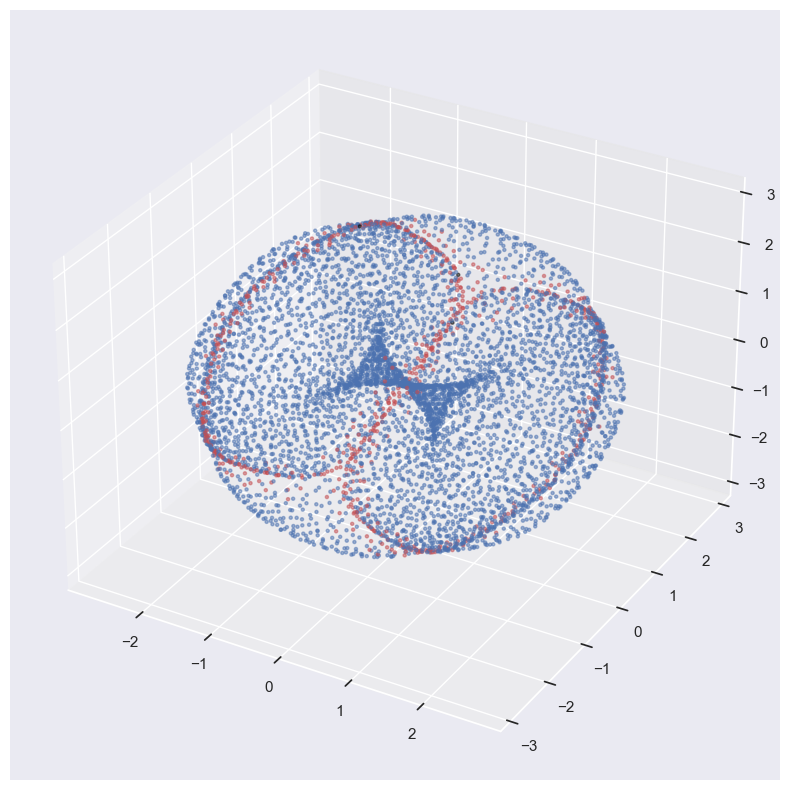

In [30]:
sns.set()
fig = plt.figure(figsize = (10,10))
ax = fig.add_subplot(projection='3d')
colormap = np.array(['black', 'b', 'r'])
ax.scatter(embedding_data[:,0], embedding_data[:,1], embedding_data[:,2], s=5, c = colormap[mask], alpha = 0.5);